# *****Implementation of SR3: Image Super-Resolution*****

>  ## SR3 is a super-resolution diffusion model that takes as input a low-resolution image, and builds a corresponding high resolution image from pure noise. The model is trained on an image corruption process in which noise is progressively added to a high-resolution image until only pure noise remains. It then learns to reverse this process, beginning from pure noise and progressively removing noise to reach a target distribution through the guidance of the input low-resolution image

### Installing necessary Libraries

In [1]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 547.3 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Importing necessary Libraries

In [2]:
from math import log10, sqrt
import numpy as np
from PIL import Image, ImageChops
import math

import torch, torchvision
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from einops import rearrange, repeat
from tqdm.notebook import tqdm
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
import math, os, copy
from IPython.display import Image

## Performance metrics

In [3]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [4]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

## SR3 MODEL

> ### U-net of SR3 : U-net backbone + Positional Encoding of time + Multihead Self-  Attention

### Forward Diffusion process: Given original image x_0, apply Gaussian noise ε_t for each time step t After proper length of time step, image x_T reachs to pure Gaussian noise

### Objective of model f: model f is trained to predict actual added noise ε_t for each time step t

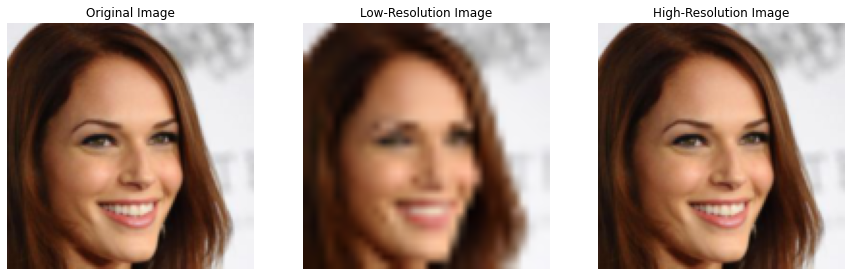

MSE between high resolution image and original image :  0.0
PSNR value between high resolution image and original image :  100
Number of model parameters : 20743011
Model loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 / loss:0.219 / val_loss:0.010


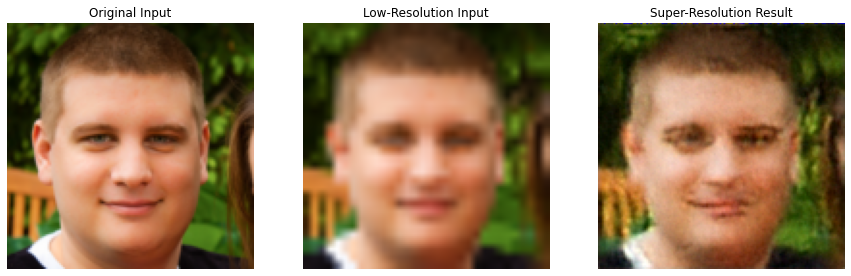

MSE between super resolution image and original input image :  0.012005399001815097
PSNR value between super resolution image and original image :  72.10825034679857


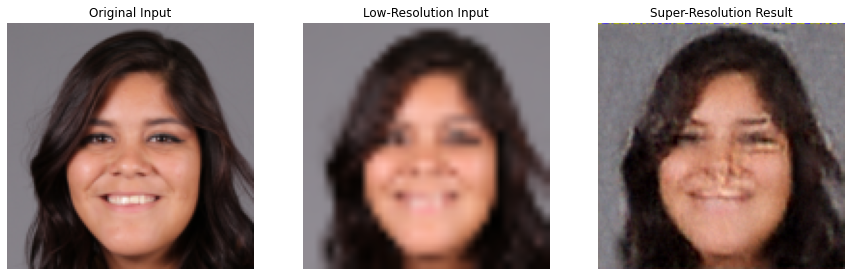

MSE between super resolution image and original input image :  0.008668659256053014
PSNR value between super resolution image and original image :  73.52249683419528
Epoch: 2 / loss:0.231 / val_loss:0.016


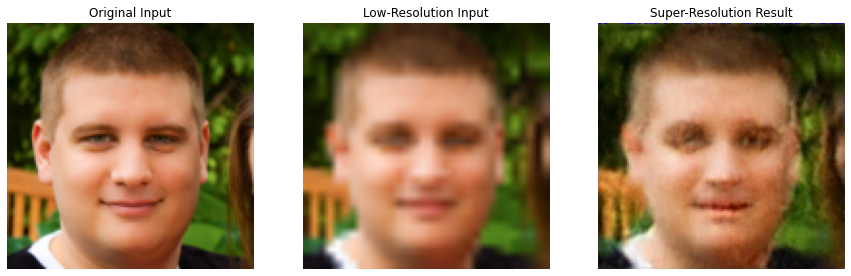

MSE between super resolution image and original input image :  0.012569435575769231
PSNR value between super resolution image and original image :  71.90885861179416


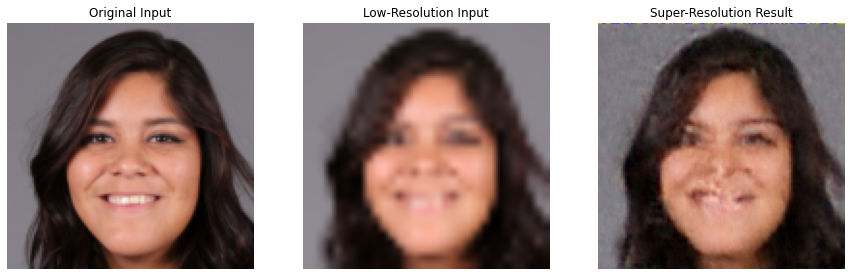

MSE between super resolution image and original input image :  0.007374087709080277
PSNR value between super resolution image and original image :  74.22493324208222
Epoch: 3 / loss:0.229 / val_loss:0.010


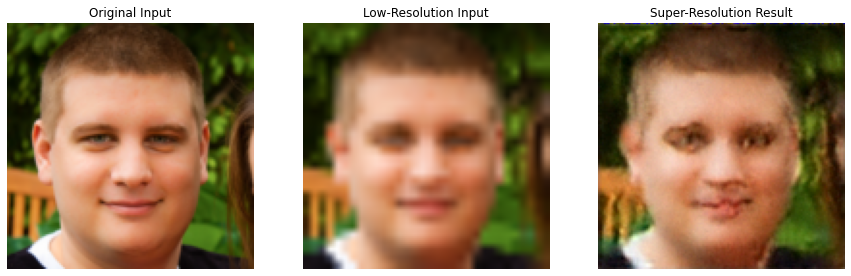

MSE between super resolution image and original input image :  0.012409121549235184
PSNR value between super resolution image and original image :  71.96460538122804


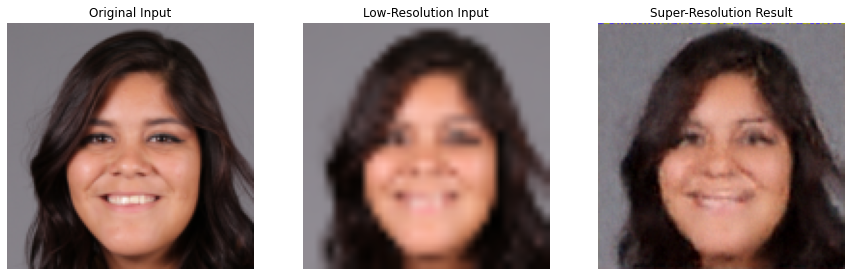

MSE between super resolution image and original input image :  0.006959612044038566
PSNR value between super resolution image and original image :  74.476165718165
Epoch: 4 / loss:0.231 / val_loss:0.020


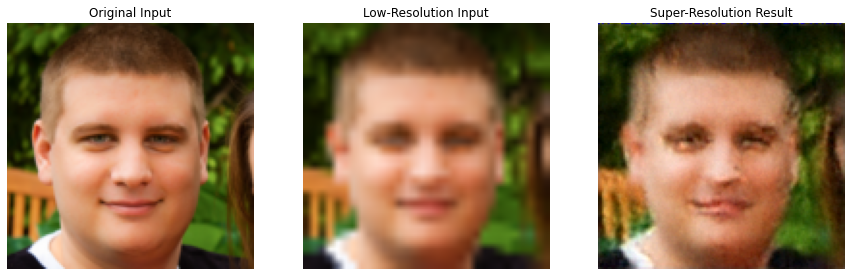

MSE between super resolution image and original input image :  0.01176405822534937
PSNR value between super resolution image and original image :  72.19644444617899


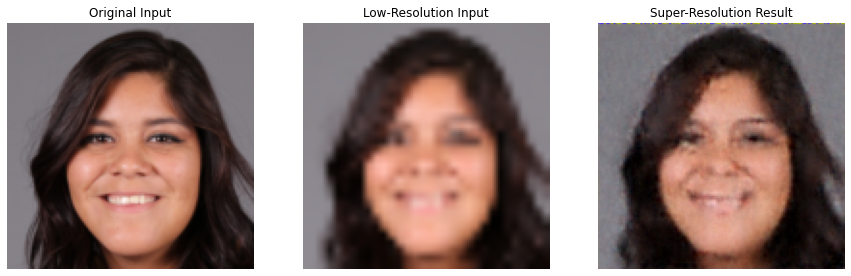

MSE between super resolution image and original input image :  0.007657075094799189
PSNR value between super resolution image and original image :  74.06138697556369
Epoch: 5 / loss:0.237 / val_loss:0.009


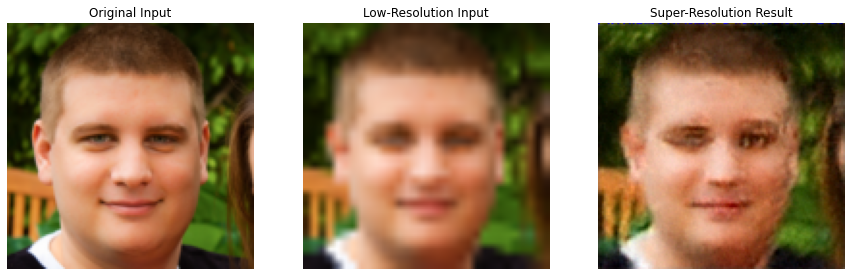

MSE between super resolution image and original input image :  0.01129417310144263
PSNR value between super resolution image and original image :  72.37347176820941


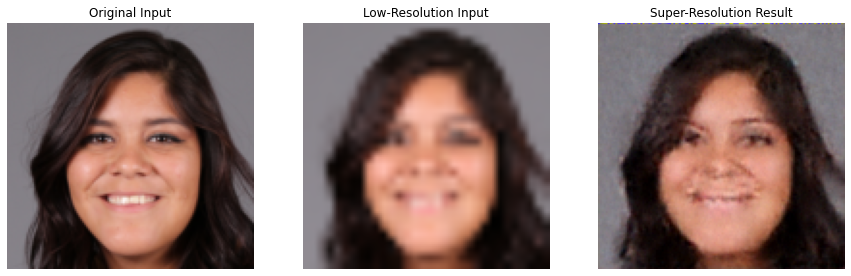

MSE between super resolution image and original input image :  0.007902941417661286
PSNR value between super resolution image and original image :  73.92412839265427


KeyboardInterrupt: 

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        # Input : tensor of value of coefficient alpha at specific step of diffusion process e.g. torch.Tensor([0.03])
        # Transform level of noise into representation of given desired dimension
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype, device=noise_level.device) / count
        encoding = noise_level.unsqueeze(1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat([torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding

class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(nn.Linear(in_channels, out_channels*(1+self.use_affine_level)))

    def forward(self, x, noise_embed):
        noise = self.noise_func(noise_embed).view(x.shape[0], -1, 1, 1)
        if self.use_affine_level:
            gamma, beta = noise.chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + noise
        return x

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))

class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)

# Linear Multi-head Self-attention
class SelfAtt(nn.Module):
    def __init__(self, channel_dim, num_heads, norm_groups=32):
        super(SelfAtt,self).__init__()        
        self.groupnorm = nn.GroupNorm(norm_groups, channel_dim)
        self.num_heads = num_heads
        self.qkv = nn.Conv2d(channel_dim, channel_dim * 3, 1, bias=False)
        self.proj = nn.Conv2d(channel_dim, channel_dim, 1)

    def forward(self,x):
        b, c, h, w = x.size()
        x = self.groupnorm(x)
        qkv = rearrange(self.qkv(x), "b (qkv heads c) h w -> (qkv) b heads c (h w)", heads=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]

        keys = F.softmax(keys, dim=-1)
        att = torch.einsum('bhdn,bhen->bhde', keys, values)
        out = torch.einsum('bhde,bhdn->bhen', att, queries)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.num_heads, h=h, w=w)

        return self.proj(out)


class ResBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, 
                    num_heads=1, use_affine_level=False, norm_groups=32, att=True):
        super().__init__()
        self.noise_func = FeatureWiseAffine(noise_level_emb_dim, dim_out, use_affine_level)
        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
        self.att = att
        self.attn = SelfAtt(dim_out, num_heads=num_heads, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        y = self.block1(x)
        y = self.noise_func(y, time_emb)
        y = self.block2(y)
        x = y + self.res_conv(x)
        if self.att:
            x = self.attn(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channel=6, out_channel=3, inner_channel=32, norm_groups=32,
        channel_mults=[1, 2, 4, 8, 8], res_blocks=3, dropout=0, img_size=128):
        super().__init__()

        noise_level_channel = inner_channel
        self.noise_level_mlp = nn.Sequential(
            PositionalEncoding(inner_channel),
            nn.Linear(inner_channel, inner_channel * 4),
            Swish(), 
            nn.Linear(inner_channel * 4, inner_channel)
        )

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = img_size

        # Downsampling stage of U-net
        downs = [nn.Conv2d(in_channel, inner_channel, kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResBlock(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, 
                    norm_groups=norm_groups, dropout=dropout))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResBlock(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, 
                            norm_groups=norm_groups, dropout=dropout),
            ResBlock(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, 
                        norm_groups=norm_groups, dropout=dropout, att=False)
        ])

        # Upsampling stage of U-net
        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResBlock(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, 
                    norm_groups=norm_groups, dropout=dropout))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, out_channel, groups=norm_groups)

    def forward(self, x, noise_level):
        # Embedding of time step with noise coefficient alpha
        t = self.noise_level_mlp(noise_level)
        
        feats = []
        for layer in self.downs:
            if isinstance(layer, ResBlock):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            x = layer(x, t)

        for layer in self.ups:
            if isinstance(layer, ResBlock):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)



class Diffusion(nn.Module):
    def __init__(self, model, device, img_size, LR_size, channels=3):
        super().__init__()
        self.channels = channels
        self.model = model.to(device)
        self.img_size = img_size
        self.LR_size = LR_size
        self.device = device

    def set_loss(self, loss_type):
        if loss_type == 'l1':
            self.loss_func = nn.L1Loss(reduction='sum')
        elif loss_type == 'l2':
            self.loss_func = nn.MSELoss(reduction='sum')
        else:
            raise NotImplementedError()

    def make_beta_schedule(self, schedule, n_timestep, linear_start=1e-4, linear_end=2e-2):
        if schedule == 'linear':
            betas = np.linspace(linear_start, linear_end, n_timestep, dtype=np.float64)
        elif schedule == 'warmup':
            warmup_frac=0.1
            betas = linear_end * np.ones(n_timestep, dtype=np.float64)
            warmup_time = int(n_timestep * warmup_frac)
            betas[:warmup_time] = np.linspace(linear_start, linear_end, warmup_time, dtype=np.float64)
        elif schedule == "cosine":
            cosine_s = 8e-3
            timesteps = torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep + cosine_s
            alphas = timesteps / (1 + cosine_s) * math.pi / 2
            alphas = torch.cos(alphas).pow(2)
            alphas = alphas / alphas[0]
            betas = 1 - alphas[1:] / alphas[:-1]
            betas = betas.clamp(max=0.999)
        else:
            raise NotImplementedError(schedule)
        return betas

    def set_new_noise_schedule(self, schedule_opt):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=self.device)

        betas = self.make_beta_schedule(
            schedule=schedule_opt['schedule'],
            n_timestep=schedule_opt['n_timestep'],
            linear_start=schedule_opt['linear_start'],
            linear_end=schedule_opt['linear_end'])
        betas = betas.detach().cpu().numpy() if isinstance(betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
        self.sqrt_alphas_cumprod_prev = np.sqrt(np.append(1., alphas_cumprod))

        self.num_timesteps = int(len(betas))
        # Coefficient for forward diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))
        self.register_buffer('pred_coef1', to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('pred_coef2', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # Coefficient for reverse diffusion posterior q(x_{t-1} | x_t, x_0)
        variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        self.register_buffer('variance', to_torch(variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch((1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    # Predict desired image x_0 from x_t with noise z_t -> Output is predicted x_0
    def predict_start(self, x_t, t, noise):
        return self.pred_coef1[t] * x_t - self.pred_coef2[t] * noise

    # Compute mean and log variance of posterior(reverse diffusion process) distribution
    def q_posterior(self, x_start, x_t, t):
        posterior_mean = self.posterior_mean_coef1[t] * x_start + self.posterior_mean_coef2[t] * x_t
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    # Note that posterior q for reverse diffusion process is conditioned Gaussian distribution q(x_{t-1}|x_t, x_0)
    # Thus to compute desired posterior q, we need original image x_0 in ideal, 
    # but it's impossible for actual training procedure -> Thus we reconstruct desired x_0 and use this for posterior
    def p_mean_variance(self, x, t, clip_denoised: bool, condition_x=None):
        batch_size = x.shape[0]
        noise_level = torch.FloatTensor([self.sqrt_alphas_cumprod_prev[t+1]]).repeat(batch_size, 1).to(x.device)
        x_recon = self.predict_start(x, t, noise=self.model(torch.cat([condition_x, x], dim=1), noise_level))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        mean, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return mean, posterior_log_variance

    # Progress single step of reverse diffusion process
    # Given mean and log variance of posterior, sample reverse diffusion result from the posterior
    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, condition_x=None):
        mean, log_variance = self.p_mean_variance(x=x, t=t, clip_denoised=clip_denoised, condition_x=condition_x)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return mean + noise * (0.5 * log_variance).exp()

    # Progress whole reverse diffusion process
    @torch.no_grad()
    def super_resolution(self, x_in):
        img = torch.rand_like(x_in, device=x_in.device)
        for i in reversed(range(0, self.num_timesteps)):
            img = self.p_sample(img, i, condition_x=x_in)
        return img

    # Compute loss to train the model
    def p_losses(self, x_in):
        x_start = x_in
        lr_imgs = transforms.Resize(self.img_size)(transforms.Resize(self.LR_size)(x_in))
        b, c, h, w = x_start.shape
        t = np.random.randint(1, self.num_timesteps + 1)
        sqrt_alpha = torch.FloatTensor(
            np.random.uniform(self.sqrt_alphas_cumprod_prev[t-1], self.sqrt_alphas_cumprod_prev[t], size=b)
        ).to(x_start.device)
        sqrt_alpha = sqrt_alpha.view(-1, 1, 1, 1)

        noise = torch.randn_like(x_start).to(x_start.device)
        # Perturbed image obtained by forward diffusion process at random time step t
        x_noisy = sqrt_alpha * x_start + (1 - sqrt_alpha**2).sqrt() * noise
        # The model predict actual noise added at time step t
        pred_noise = self.model(torch.cat([lr_imgs, x_noisy], dim=1), noise_level=sqrt_alpha)
        
        return self.loss_func(noise, pred_noise)

    def forward(self, x, *args, **kwargs):
        return self.p_losses(x, *args, **kwargs)


# Class to train & test desired model
class SR3():
    def __init__(self, device, img_size, LR_size, loss_type, dataloader, testloader, 
                    schedule_opt, save_path, load_path=None, load=False, 
                    in_channel=6, out_channel=3, inner_channel=32, norm_groups=8, 
                    channel_mults=(1, 2, 4, 8, 8), res_blocks=3, dropout=0, lr=1e-5, distributed=False):
        super(SR3, self).__init__()
        self.dataloader = dataloader
        self.testloader = testloader
        self.device = device
        self.save_path = save_path
        self.img_size = img_size
        self.LR_size = LR_size

        model = UNet(in_channel, out_channel, inner_channel, norm_groups, channel_mults, res_blocks, dropout, img_size)
        self.sr3 = Diffusion(model, device, img_size, LR_size, out_channel)

        # Apply weight initialization & set loss & set noise schedule
        self.sr3.apply(self.weights_init_orthogonal)
        self.sr3.set_loss(loss_type)
        self.sr3.set_new_noise_schedule(schedule_opt)

        if distributed:
            assert torch.cuda.is_available()
            self.sr3 = nn.DataParallel(self.sr3)

        self.optimizer = torch.optim.Adam(self.sr3.parameters(), lr=lr)

        params = sum(p.numel() for p in self.sr3.parameters())
        print(f"Number of model parameters : {params}")

        if load:
            self.load(load_path)

    def weights_init_orthogonal(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            init.orthogonal_(m.weight.data, gain=1)
            if m.bias is not None:
                m.bias.data.zero_()
        elif classname.find('Linear') != -1:
            init.orthogonal_(m.weight.data, gain=1)
            if m.bias is not None:
                m.bias.data.zero_()
        elif classname.find('BatchNorm2d') != -1:
            init.constant_(m.weight.data, 1.0)
            init.constant_(m.bias.data, 0.0)

    def train(self, epoch, verbose):
        fixed_imgs1 = copy.deepcopy(next(iter(self.testloader)))
        fixed_imgs1 = fixed_imgs1[0].to(self.device)
        # Transform to low-resolution images
        fixed_imgs = transforms.Resize(self.img_size)(transforms.Resize(self.LR_size)(fixed_imgs1))

        for i in tqdm(range(epoch)):
            train_loss = 0
            for _, imgs in enumerate(self.dataloader):
                # Initial imgs are high-resolution
                imgs = imgs[0].to(self.device)
                b, c, h, w = imgs.shape
    
                self.optimizer.zero_grad()
                loss = self.sr3(imgs)
                loss = loss.sum() / int(b*c*h*w)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * b

            self.sr3.eval()
            test_imgs = next(iter(self.testloader))
            test_imgs = test_imgs[0].to(self.device)
            b, c, h, w = test_imgs.shape

            with torch.no_grad():
                val_loss = self.sr3(test_imgs)
                val_loss = val_loss.sum() / int(b*c*h*w)
            self.sr3.train()

            train_loss = train_loss / len(self.dataloader)
            print(f'Epoch: {i+1} / loss:{train_loss:.3f} / val_loss:{val_loss.item():.3f}')

            for k in range(0,2):
                plt.figure(figsize=(15,10))
                plt.subplot(1,3,1)
                plt.axis("off")
                plt.title("Original Input")
                original=np.transpose(torchvision.utils.make_grid(fixed_imgs1[k:k+1], nrow=2, padding=1, normalize=True).cpu(),(1,2,0))
                plt.imshow(original)

                plt.subplot(1,3,2)
                plt.axis("off")
                plt.title("Low-Resolution Input")
                low=np.transpose(torchvision.utils.make_grid(fixed_imgs[k:k+1],nrow=2, padding=1, normalize=True).cpu(),(1,2,0))
                plt.imshow(low)

                plt.subplot(1,3,3)
                plt.axis("off")
                plt.title("Super-Resolution Result")
                high=np.transpose(torchvision.utils.make_grid(self.test(fixed_imgs[k:k+1]).detach().cpu(),nrow=2, padding=1, normalize=True),(1,2,0))
                plt.imshow(high)
                plt.show()
                
                original1 = original.numpy()
                low1 = low.numpy()
                high1 = high.numpy()
                print("MSE between super resolution image and original input image : ",mse(original1, high1))
                print("PSNR value between super resolution image and original image : ",PSNR(original1, high1))

            # Save model weight
            self.save(self.save_path)

    def test(self, imgs):
        imgs_lr = transforms.Resize(self.img_size)(transforms.Resize(self.LR_size)(imgs))
        self.sr3.eval()
        with torch.no_grad():
            if isinstance(self.sr3, nn.DataParallel):
                result_SR = self.sr3.module.super_resolution(imgs_lr)
            else:
                result_SR = self.sr3.super_resolution(imgs_lr)
        self.sr3.train()
        return result_SR

    def save(self, save_path):
        network = self.sr3
        if isinstance(self.sr3, nn.DataParallel):
            network = network.module
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, save_path)

    def load(self, load_path):
        network = self.sr3
        if isinstance(self.sr3, nn.DataParallel):
            network = network.module
        network.load_state_dict(torch.load(load_path))
        print("Model loaded successfully")


if __name__ == "__main__":
    batch_size = 8
    LR_size = 32
    img_size = 128
    root = '/kaggle/input/celebahq-resized-256x256'
    testroot = '/kaggle/input/faces-dataset-small'

    transforms_ = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(), 
                                        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    dataloader = DataLoader(torchvision.datasets.ImageFolder(root, transform=transforms_),
                            batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    testloader = DataLoader(torchvision.datasets.ImageFolder(testroot, transform=transforms_), 
                            batch_size=5, shuffle=True, num_workers=2, pin_memory=True)

    imgs, _ = next(iter(dataloader))
    LR_imgs = transforms.Resize(img_size)(transforms.Resize(LR_size)(imgs))
    plt.figure(figsize=(15,10))
    plt.subplot(1,3,1)
    plt.axis("off")
    plt.title("Original Image")
    original=np.transpose(torchvision.utils.make_grid(imgs[:1], padding=1, normalize=True).cpu(),(1,2,0))
    plt.imshow(original)

    plt.subplot(1,3,2)
    plt.axis("off")
    plt.title("Low-Resolution Image")
    low=np.transpose(torchvision.utils.make_grid(LR_imgs[:1], padding=1, normalize=True).cpu(),(1,2,0))
    plt.imshow(low)

    plt.subplot(1,3,3)
    plt.axis("off")
    plt.title("High-Resolution Image")
    high=np.transpose(torchvision.utils.make_grid(imgs[:1], padding=1, normalize=True).cpu(),(1,2,0))
    plt.imshow(high)
    plt.show()
    
    original1 = original.numpy()
    low1 = low.numpy()
    high1 = high.numpy()
    print("MSE between high resolution image and original image : ",mse(original1, high1))
    print("PSNR value between high resolution image and original image : ",PSNR(original1, high1))

    cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if cuda else "cpu")
    schedule_opt = {'schedule':'linear', 'n_timestep':2000, 'linear_start':1e-4, 'linear_end':0.05}

    sr3 = SR3(device, img_size=img_size, LR_size=LR_size, loss_type='l1', 
                dataloader=dataloader, testloader=testloader, schedule_opt=schedule_opt, 
                save_path='sr3.pt',load_path='/kaggle/input/sr-saved2/sr3.pt' ,load=True, inner_channel=96, 
                norm_groups=16, channel_mults=(1, 2, 2, 2), dropout=0.2, res_blocks=2, lr=1e-5, distributed=False)
    sr3.train(epoch=20, verbose=1)